In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# personal helper functions 
from helper_functions.nlp_helper_functions import punctuation_cntr, Lcase_counter, Ucase_counter


In [3]:
df_main = pd.read_csv('../data/cleaned_main.csv')

# importing train/test data with features created in Logistic Regression notebook 
train_whole = pd.read_csv('../data/train_test_whole_dfs/train_whole.csv')
y3_train = pd.read_csv('../data/train_test_whole_dfs/y_train.csv').reset_index(drop=True)
test_whole = pd.read_csv('../data/train_test_whole_dfs/test_whole.csv')
y3_test = pd.read_csv('../data/train_test_whole_dfs/y_test.csv').reset_index(drop=True)
df_main.head()

,selftext,title,target
0,There are a lot of chauvinists in the U S who ...,Is Kamala Harris more at risk of assassination...,0
1,Let me explain The name of your movement shoul...,A push labeled Let mothers hold their babies,0
2,I have read about some horrific pit bull attac...,Why don t we see politicians supporting pit bu...,0
3,Some international observers have argued that ...,What threat does EU expansion pose towards Russia,0
4,Every definition of the term implies cheating ...,Why is gerrymandering legal,0


In [ ]:
print('train whole shape: ',train_whole.shape,y3_train.shape)
print('test whole shape: ',test_whole.shape, y3_test.shape)
# # should return the following
# train whole shape:  (1485, 3005) (1485,)
# test whole shape:  (496, 3005) (496,)

train whole shape:  (1485, 3003) (1485, 1)
test whole shape:  (496, 3003) (496, 1)


In [ ]:
# sanity check that this is still representative of a train_test_split 
print(y3_train.value_counts(normalize=True))
y3_test.value_counts(normalize=True)

class
0        0.50303
1        0.49697
dtype: float64


class
0        0.504032
1        0.495968
dtype: float64

In [4]:
# refresher of baseline accuracy (what we want to perform better)
df_main['target'].value_counts(normalize=True)[0]

0.5032811711256941

--- 
Model Random Forest

This first iteration will be performed with the original dataset to determine if this model is a stronger performer than the Logistic Regression model.

In [6]:
# reminder of renaming of column to account for the actual 'target' word found in the selftext
y3_test.head(2)

,class
0,1
1,0


cross val score:  0.7481481481481482
best score:  0.7542087542087541
best params:  {'max_depth': None, 'n_estimators': 150}
This is the baseline we want to perform better than 0.5032811711256941
training score:  0.997979797979798
test score:  0.7943548387096774


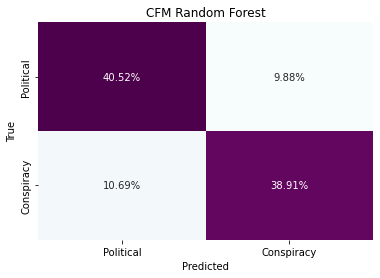

In [ ]:
# RANDOM FOREST ON ORIGINAL DATASET WITHOUT (UPPER/LOWER CASE COUNT OR PUNCTUATION COUNT )
X = df_main.drop(columns=['target'])
y = df_main['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

# instantiate a vectorizer with parameters from grid search used to create (whole train/test dataframes in model above)
cvec = CountVectorizer(stop_words='english', # eliminating the basic stop words
                       binary=True,
                       lowercase =False, # we want to pay attention to case sensitivity later
                        max_df= 0.75, # this is a form of creating a customized stop words list 
                        max_features= 3000,ngram_range=(1,1) ) 

# fit and transform on self text
Xv_train = cvec.fit_transform(X_train['selftext'])
Xv_test = cvec.transform(X_test['selftext'])

# Convert X_train and X_test into a DataFrame.
Xv_train_rf = pd.DataFrame(Xv_train.todense(),columns=cvec.get_feature_names())
Xv_test_rf = pd.DataFrame(Xv_test.todense(),columns=cvec.get_feature_names())

# initializing random forest model + grid search params
rf = RandomForestClassifier(n_estimators=100)  # only creating 100 decision tree
print('cross val score: ',cross_val_score(rf, Xv_train_rf, y_train, cv = 5).mean())
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth':[None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid = rf_params,
                 cv = 5, n_jobs = -1)
# fitting to training data/outputing model evaluation
gs.fit(Xv_train_rf, y_train)
print('best score: ',gs.best_score_)
print('best params: ',gs.best_params_)
print('This is the baseline we want to perform better than',y.value_counts(normalize=True)[0])
print('training score: ',gs.score(Xv_train_rf,y_train))
print('test score: ',gs.score(Xv_test_rf,y_test))

# checking results of confusion matrix on original dataframe (count vectorizer)
cf_matrix = confusion_matrix(y_test, gs.predict(Xv_test_rf))

cmd_obj = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap="BuPu", cbar=False,xticklabels=['Political','Conspiracy'],
            yticklabels=['Political','Conspiracy']);
## also controls the title.
cmd_obj
plt.title('CFM Random Forest',color='black');
plt.xlabel('Predicted',color='black');
plt.ylabel('True',color='black');


Note: <br>
The model is clearly overfit and could use a drastic amount of work to improve not only the overfitting but the accuracy score as well to raise it to the point of the logstic regression model. If more time was provided this would be done, however since it is not the focus of the project will not iterate as heaviliy below. This model is mainly for exploration purposes.




This model is performing fairly decent for just a basic iteration on the original data. However we will look at how it performs with the additional features I created in the Logistic Regression.

cross val score 0.8242424242424242
0.8215488215488215
training score:  1.0
testing score: 0.8629032258064516


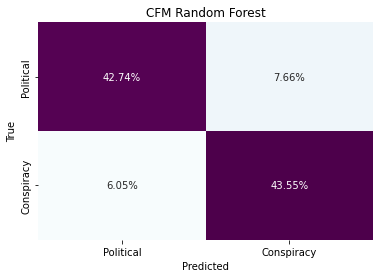

In [ ]:
# First attempt with random forest (After Features introduced: Upper/Lower Case & Punctuation Count) 
y3_train = y3_train['class'].copy()
y3_test = y3_test['class'].copy()
rf = RandomForestClassifier(n_estimators=100)  # only creating 100 decision tree
print('cross val score',cross_val_score(rf, train_whole, y3_train, cv = 5).mean())
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth':[None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid = rf_params,
                 cv = 5, n_jobs = -1)

gs.fit(train_whole, y3_train)
print(gs.best_score_)
gs.best_params_
print('training score: ',gs.score(train_whole,y3_train))
print('testing score:',gs.score(test_whole,y3_test))

# checking results of confusion matrix with tfid vectorizer
cf_matrix = confusion_matrix(y3_test, gs.predict(test_whole))

cmd_obj = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap="BuPu", cbar=False,xticklabels=['Political','Conspiracy'],
            yticklabels=['Political','Conspiracy']);
## also controls the title.
cmd_obj
plt.title('CFM Random Forest',color='black');
plt.xlabel('Predicted',color='black');
plt.ylabel('True',color='black');


Note:
We can clearly see that including the additional features drastically improved our score to the point of nearly where are best Logistic model was performing. The imbalance of our classification tends to hold as well in the Random Forest model as it did in the Logistic iterations.

For exploration purposes we will examine how the random forest model performs with only the sentiment analysis, now remember none of the sentiment analyses should any high correlations with our target variable so we should not expect anything marevelous. 

--- 
Utilizing sentiment analysis for exploration only

In [ ]:
sentiment_whole = pd.read_csv('../data/sentiment_whole.csv')
# there should not be any nulls but in case
sentiment_whole.dropna(inplace=True)
# note will use the counts from this csv moving forward
sentiment_whole.head()

,neg,neu,pos,compound,text,selftext,title,target,punctuation_count,word_count
0,0.104,0.789,0.107,0.2955,There are a lot of chauvinists in the U.S. who...,There are a lot of chauvinists in the U.S. who...,Is Kamala Harris more at risk of assassination...,0.0,60.0,206.0
1,0.067,0.804,0.129,0.7897,Let me explain. The name of your movement shou...,Let me explain. The name of your movement shou...,"A push labeled ""Let mothers hold their babies""",0.0,120.0,454.0
2,0.263,0.737,0.000,-0.9559,I have read about some horrific pit bull attac...,I have read about some horrific pit bull attac...,Why don't we see politicians supporting pit bu...,0.0,77.0,267.0
3,0.109,0.737,0.154,0.4606,Some international observers have argued that...,Some international observers have argued that...,What threat does EU expansion pose towards Rus...,0.0,82.0,412.0
4,0.146,0.854,0.000,-0.5574,Every definition of the term implies cheating....,Every definition of the term implies cheating....,Why is gerrymandering legal?,0.0,24.0,98.0


cross val score:  0.7595027870680044
best score:  0.7635250836120402
best params:  {'max_depth': None, 'n_estimators': 100}
This is the baseline we want to perform better than 0.500501002004008
training score:  0.9986639946559787
test score:  0.7835671342685371


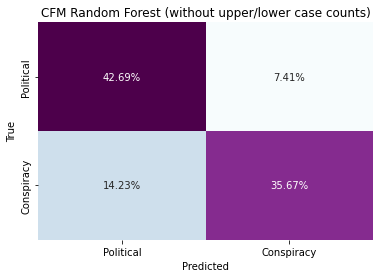

In [ ]:
# Random forest using sentiment analysis (excluding lower/uppercase counts)
X = sentiment_whole.drop(columns=['target'])
y = sentiment_whole['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

# instantiate a vectorizer with parameters from grid search used to create (whole train/test dataframes in model above)
cvec = CountVectorizer(stop_words='english', # eliminating the basic stop words
                       binary=True,
                       lowercase =False, # we want to pay attention to case sensitivity later
                        max_df= 0.75, # this is a form of creating a customized stop words list 
                        max_features= 3000,ngram_range=(1,1) ) 

# fit and transform on self text
Xv_train = cvec.fit_transform(X_train['selftext'])
Xv_test = cvec.transform(X_test['selftext'])

# Convert X_train and X_test into a DataFrame.
Xv_train_rf = pd.DataFrame(Xv_train.todense(),columns=cvec.get_feature_names())
Xv_test_rf = pd.DataFrame(Xv_test.todense(),columns=cvec.get_feature_names())

# initializing random forest model + grid search params
rf = RandomForestClassifier(n_estimators=100)  # only creating 100 decision tree
print('cross val score: ',cross_val_score(rf, Xv_train_rf, y_train, cv = 5).mean())
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth':[None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid = rf_params,
                 cv = 5, n_jobs = -1)
# fitting to training data/outputing model evaluation
gs.fit(Xv_train_rf, y_train)
print('best score: ',gs.best_score_)
print('best params: ',gs.best_params_)
print('This is the baseline we want to perform better than',y.value_counts(normalize=True)[0])
print('training score: ',gs.score(Xv_train_rf,y_train))
print('test score: ',gs.score(Xv_test_rf,y_test))

# checking results of confusion matrix on original dataframe (count vectorizer)
cf_matrix = confusion_matrix(y_test, gs.predict(Xv_test_rf))

cmd_obj = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap="BuPu", cbar=False,xticklabels=['Political','Conspiracy'],
            yticklabels=['Political','Conspiracy']);
## also controls the title.
cmd_obj
plt.title('CFM Random Forest (without upper/lower case counts)',color='black');
plt.xlabel('Predicted',color='black');
plt.ylabel('True',color='black');

Unfortunately as expeceted this model did not perform highly on just the sentiment analysis, an interesting attempt can be made in the future to include the setiment analysis this the vectorized data then try to make predictions on our text. However, it has the potential to be as 'fruitful' as when we introduced our features to the logistic regression so to continue addressing the problem for Serra we will not move forward and explore the final conclusions in the Logistic Regression notebook.